In [1]:
# Supress warnings and import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import numpy as np
import scipy as sp
from matplotlib import pyplot
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.rrule import rrule, DAILY
from scipy.stats import mstats

import statsmodels.tsa as ts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from statsmodels.tsa.api import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.stattools as stt

In [2]:
inputData = pd.read_csv(r"E:\Rajeev\IIITB\ML&AI\Capston_Project\Project\data\data\inputDataProcessed.csv", encoding = 'ISO-8859-1')
inputData.head()

,Store,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,1,01-01-2013,5530,668,0,1,1270,0,1,0,0,0,0,0
1,1,02-01-2013,4327,578,0,1,1270,0,0,1,0,0,0,0
2,1,03-01-2013,4486,619,0,1,1270,0,0,0,1,0,0,0
3,1,04-01-2013,4997,635,0,1,1270,0,0,0,0,1,0,0
4,1,05-01-2013,7176,785,1,1,1270,0,0,0,0,0,1,0


In [3]:
n = len(pd.unique(inputData['Store']))
print(n)

i=9

15


In [4]:
# plot sales data
storeDataAll=inputData.loc[inputData["Store"]==i]
storeDataAll=storeDataAll.reset_index(drop=True)

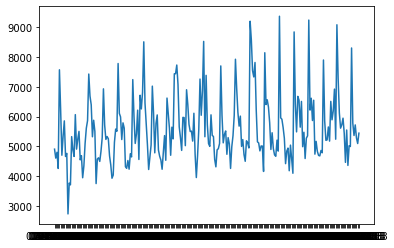

In [5]:
# Create figure and plot space
        
plt.plot( storeDataAll.iloc[0:250,1],storeDataAll.iloc[0:250,2])

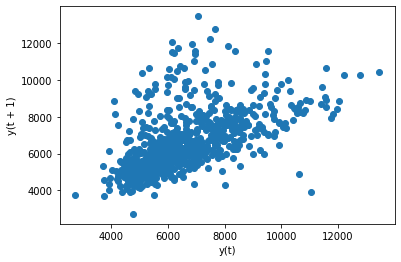

In [6]:
# Autocorrelation of sales data
lag_plot(storeDataAll.iloc[:,2])

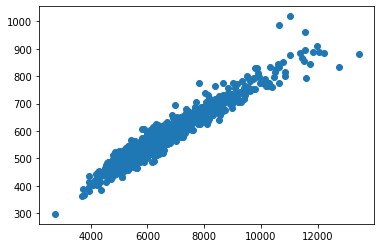

In [7]:
plt.scatter(storeDataAll['Sales'],storeDataAll['Customers'])

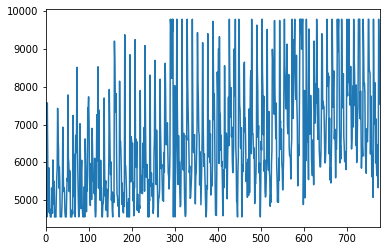

In [8]:
#cap sales Data
transformed_test_data1 = pd.Series(mstats.winsorize(storeDataAll['Sales'], limits=[0.05, 0.05])) 
transformed_test_data1.plot()  

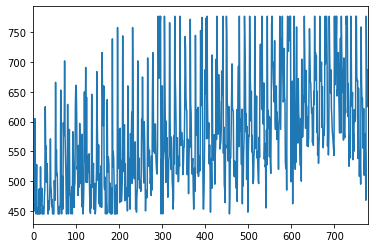

In [9]:
#cap customers Data
transformed_test_data2 = pd.Series(mstats.winsorize(storeDataAll['Customers'], limits=[0.05, 0.05])) 
transformed_test_data2.plot()

In [10]:
# get transformed values
storeDataAll.iloc[:,2]=transformed_test_data1.values
storeDataAll.iloc[:,3]=transformed_test_data2.values

In [21]:
storeDataAll.head()

,Store,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,SalesSeasonality,SalesTrend,CustSeasonality,CustTrend
0,9,01-01-2013,4903,481,0,1,2030,0,0,0,0,0,1,0,1507.627629,5311.927557,103.979342,493.218919
1,9,02-01-2013,4602,453,0,1,2030,0,0,0,0,0,0,1,-68.684559,5315.099840,-8.985970,493.444692
2,9,03-01-2013,4798,497,0,1,2030,1,0,0,0,0,0,0,-86.686245,5318.272123,18.379312,493.670465
3,9,04-01-2013,4559,450,0,0,2030,0,1,0,0,0,0,0,-620.677885,5321.444407,-33.177781,493.896239
4,9,05-01-2013,7574,605,1,0,2030,0,0,1,0,0,0,0,99.124995,5324.616690,-25.977797,494.122012


In [23]:
storeDataAll.shape

(779, 18)

-7.676707775101029


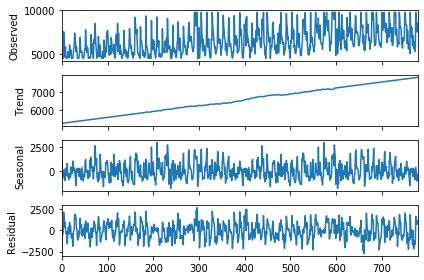

In [11]:
################# get seasonality and trend ##########################
##### change code to include search for best sesonality using freq#############
    
result = seasonal_decompose((storeDataAll.iloc[:,2]), model='additive', freq=365, extrapolate_trend='freq')
result.plot()
print(result.resid.mean())
storeDataAll["SalesSeasonality"]=result.seasonal
storeDataAll["SalesTrend"]=result.trend

# plot_acf(storeDataAll.iloc[:,2])

-1.5278465512046522


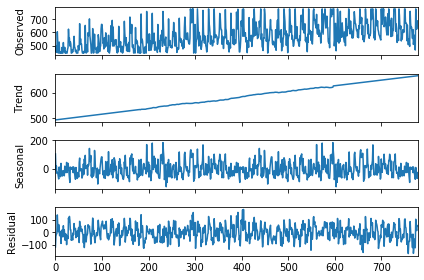

In [12]:
################# get seasonality and trend ##########################
##### change codde to include search for best sesonality using freq#############
result = seasonal_decompose((storeDataAll.iloc[:,3]), model='additive', freq=365, extrapolate_trend='freq')
result.plot()
print(result.resid.mean())
#plot_acf(storeDataAll.iloc[:,3])
storeDataAll["CustSeasonality"]=result.seasonal
storeDataAll["CustTrend"]=result.trend

In [13]:
###### split data into train and test #########################################
storeOneData, TestData=storeDataAll[:-100], storeDataAll[-100:]
storeOneData.shape

(679, 18)

In [14]:
TestData.shape

(100, 18)

In [25]:
storeOneData

,Store,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,SalesSeasonality,SalesTrend,CustSeasonality,CustTrend
0,9,01-01-2013,4903,481,0,1,2030,0,0,0,0,0,1,0,1507.627629,5311.927557,103.979342,493.218919
1,9,02-01-2013,4602,453,0,1,2030,0,0,0,0,0,0,1,-68.684559,5315.099840,-8.985970,493.444692
2,9,03-01-2013,4798,497,0,1,2030,1,0,0,0,0,0,0,-86.686245,5318.272123,18.379312,493.670465
3,9,04-01-2013,4559,450,0,0,2030,0,1,0,0,0,0,0,-620.677885,5321.444407,-33.177781,493.896239
4,9,05-01-2013,7574,605,1,0,2030,0,0,1,0,0,0,0,99.124995,5324.616690,-25.977797,494.122012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,9,06-11-2014,5594,556,0,0,2030,1,0,0,0,0,0,0,-697.911339,7446.844586,-22.296219,643.790597
675,9,07-11-2014,6414,582,0,0,2030,0,1,0,0,0,0,0,-697.846904,7450.011607,-55.181986,644.011446
676,9,08-11-2014,6346,577,0,0,2030,0,0,1,0,0,0,0,-685.493428,7453.178628,-26.481451,644.232294
677,9,09-11-2014,6970,596,0,0,2030,0,0,0,1,0,0,0,-769.855021,7456.345649,-51.185026,644.453142


In [15]:
#################### causality test####################################
## null hypothesis is: x does not granger cause y #####################
## if value of p is less than 0.05 then granger causality exists ######
    
CausalitySales=(ts.stattools.grangercausalitytests(storeOneData[['Sales','Customers']].dropna(),1))
print(CausalitySales)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2058 , p=0.0005  , df_denom=675, df_num=1
ssr based chi2 test:   chi2=12.2601 , p=0.0005  , df=1
likelihood ratio test: chi2=12.1505 , p=0.0005  , df=1
parameter F test:         F=12.2058 , p=0.0005  , df_denom=675, df_num=1
{1: ({'ssr_ftest': (12.205826243057324, 0.0005075179667344736, 675.0, 1), 'ssr_chi2test': (12.260074359693133, 0.0004627530686445736, 1), 'lrtest': (12.150545121643518, 0.0004907351909535668, 1), 'params_ftest': (12.205826243057388, 0.0005075179667344736, 675.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000018AB4F10E08>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000018AB3DD7848>, array([[0., 1., 0.]])])}


In [16]:
CausalityCust=(ts.stattools.grangercausalitytests(storeOneData[['Customers','Sales']].dropna(),1))
print(CausalityCust)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=36.7752 , p=0.0000  , df_denom=675, df_num=1
ssr based chi2 test:   chi2=36.9387 , p=0.0000  , df=1
likelihood ratio test: chi2=35.9675 , p=0.0000  , df=1
parameter F test:         F=36.7752 , p=0.0000  , df_denom=675, df_num=1
{1: ({'ssr_ftest': (36.7752101329841, 2.206791441766586e-09, 675.0, 1), 'ssr_chi2test': (36.93865551135292, 1.2190492751443228e-09, 1), 'lrtest': (35.967530208809876, 2.0063315850097102e-09, 1), 'params_ftest': (36.775210132984114, 2.206791441766586e-09, 675.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000018AB4F0C308>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000018AB4F0C048>, array([[0., 1., 0.]])])}


In [17]:
####################### stationarity of sales ##################################
## null hypothesis is there is nonstationarity ########################
## if p<0.05 then series is staionary no differencing reqd ############

stationSales=adfuller(storeOneData.iloc[:,2], autolag='AIC')
print('ADF Statistic: %f' % stationSales[0])
print('p-value: %f' % stationSales[1])


if stationSales[4]['5%'] < stationSales[0]:
    stationSalesDIF=adfuller(storeOneData.iloc[:,3].diff().dropna(), autolag='AIC')
    print('ADF Statistic DIFF: %f' % stationSalesDIF[0])
    print('p-value DIFF: %f' % stationSalesDIF[1])

print(stationSales)

ADF Statistic: -2.671509
p-value: 0.079100
ADF Statistic DIFF: -9.534996
p-value DIFF: 0.000000
(-2.6715091655286045, 0.07909951080411748, 20, 658, {'1%': -3.4403271946832645, '5%': -2.8659424728408456, '10%': -2.5691144817582985}, 10984.022945389323)


In [18]:
####################### stationarity of customers ##################################
## null hypothesis is there is nonstationarity ########################
## if p<0.05 then series is staionary no differencing reqd ############

stationCust=adfuller(storeOneData.iloc[:,3], autolag='AIC')
print('ADF Statistic: %f' % stationCust[0])
print('p-value: %f' % stationCust[1])
    
if stationCust[4]['5%'] < stationCust[0]:
    stationCustDIF=adfuller(storeOneData.iloc[:,3].diff().dropna(), autolag='AIC')
    print('ADF Statistic DIFF: %f' % stationCustDIF[0])
    print('p-value DIFF: %f' % stationCustDIF[1])

print(stationCust)

ADF Statistic: -2.545604
p-value: 0.104769
ADF Statistic DIFF: -9.534996
p-value DIFF: 0.000000
(-2.545603735810787, 0.1047689291600416, 20, 658, {'1%': -3.4403271946832645, '5%': -2.8659424728408456, '10%': -2.5691144817582985}, 7404.7820667536635)


In [28]:
storeDataAll['SalesSeasonality']

0      1507.627629
1       -68.684559
2       -86.686245
3      -620.677885
4        99.124995
          ...     
774     375.867607
775    -124.135905
776    -703.196952
777   -1056.590419
778    -366.468817
Name: SalesSeasonality, Length: 779, dtype: float64

In [31]:
storeDataAll["SalesTrend"]

0      5311.927557
1      5315.099840
2      5318.272123
3      5321.444407
4      5324.616690
          ...     
774    7763.546685
775    7766.713706
776    7769.880727
777    7773.047748
778    7776.214769
Name: SalesTrend, Length: 779, dtype: float64

In [30]:
storeDataAll["CustSeasonality"]

0      103.979342
1       -8.985970
2       18.379312
3      -33.177781
4      -25.977797
          ...    
774      7.990535
775    -22.705370
776    -54.321824
777    -69.929146
778    -28.297198
Name: CustSeasonality, Length: 779, dtype: float64

In [29]:
storeDataAll['CustTrend']

0      493.218919
1      493.444692
2      493.670465
3      493.896239
4      494.122012
          ...    
774    665.875425
775    666.096273
776    666.317121
777    666.537969
778    666.758818
Name: CustTrend, Length: 779, dtype: float64

In [32]:
# define endogenous and exogenous variables

endog=storeOneData[['Sales', 'Customers']].astype('float32')
    
exog= storeOneData[['Promo', 'SchoolHoliday',
                        'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
                        'DayOfWeek_4','DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_0', 'SalesSeasonality',
                        'SalesTrend', 'CustSeasonality', 'CustTrend']]
exog= exog.astype('float32')
endog=endog.astype('float32')

In [33]:
endog

,Sales,Customers
0,4903.0,481.0
1,4602.0,453.0
2,4798.0,497.0
3,4559.0,450.0
4,7574.0,605.0
...,...,...
674,5594.0,556.0
675,6414.0,582.0
676,6346.0,577.0
677,6970.0,596.0


In [34]:
exog

,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_0,SalesSeasonality,SalesTrend,CustSeasonality,CustTrend
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1507.627686,5311.927734,103.979340,493.218933
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-68.684563,5315.099609,-8.985970,493.444702
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-86.686249,5318.271973,18.379313,493.670471
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-620.677856,5321.444336,-33.177780,493.896240
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,99.124992,5324.616699,-25.977797,494.122009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-697.911316,7446.844727,-22.296219,643.790588
675,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-697.846924,7450.011719,-55.181988,644.011475
676,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-685.493408,7453.178711,-26.481451,644.232300
677,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-769.855042,7456.345703,-51.185024,644.453125


In [35]:
# get the differenced series if required

endogdif1=endog.diff().dropna()
exogdif1=exog.diff().dropna()

endogdif11=endog.iloc[:,0].diff().dropna()
endogdif1.iloc[:,0]=endogdif11.values

endogdif12=endog.iloc[:,1].diff().dropna()
endogdif1.iloc[:,1]=endogdif12.values

#TestDatadif1=TestData.diff().dropna()


In [36]:
#################### cointegration Analysis if required###################################
## null hypothesis is that there is no cointegration ##########################
## to be tested if ADF test says non-stationarity #############################

coint=coint_johansen(endogdif1,0,1)
coint.trace_stat
coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = endogdif1.shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)



rank=select_coint_rank(endogdif1,0,1)
print(rank.rank)
#result=stt.coint(endog['Sales'], endog['Customers'])

#mod = VECM(endogdif1, exog=exogdif1) #endogdif1, exogdif1 
#res = mod.fit() #maxiter=500, disp=False
#res.hessian()
#print(res.summary())

AttributeError: 'Holder' object has no attribute 'trace_stat'

In [37]:
# specify VAR model at levels
mod = VAR(endogdif1, exog=exogdif1) #, order=(2,0,0)

aa=mod.select_order()
aa.summary
print(aa.aic)
res=mod.fit(maxlags=aa.aic, ic='aic')
lag_order = res.k_ar
res.summary()

C:\Users\Rajeev K Pandit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Jan, 2021
Time:                     17:46:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.6185
Nobs:                     660.000    HQIC:                   19.2017
Log likelihood:          -8022.51    FPE:                1.67834e+08
AIC:                      18.9379    Det(Omega_mle):     1.45028e+08
--------------------------------------------------------------------
Results for equation Sales
                   coefficient         std. error           t-stat            prob
----------------------------------------------------------------------------------
const                -2.411224          32.597068           -0.074           0.941
exog0              1346.152788          91.001570           14.793           0.000
exog1               158.951682          96.918686   

In [38]:
# specify VARMAX model

mod = VARMAX(endogdif1, exog=exogdif1,order=(18,0), trend='n') #endogdif1, exogdif1 
res = mod.fit(maxiter=100, disp=False) #maxiter=500, disp=False
#res.hessian()
print(res.summary())
print(res.params)

C:\Users\Rajeev K Pandit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Rajeev K Pandit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  678
Model:                           VARX(18)   Log Likelihood              -10657.104
Date:                    Sun, 10 Jan 2021   AIC                          21516.207
Time:                            17:58:34   BIC                          21972.641
Sample:                                 0   HQIC                         21692.906
                                    - 678                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              154.98, 907.45   Jarque-Bera (JB):         151.85, 6.43
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.04
Heteroskedasticity (H):         1.02, 1.00   Skew:                     -0.09, -0.07
Prob(H) (two-sided):            0.89, 0.99   Kurtosis:                   5.31, 3.46


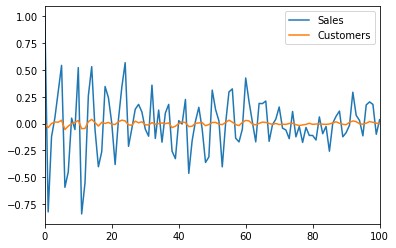

In [39]:
# get impulse response functions
irf=res.impulse_responses(steps=100, orthogonalized=False)
irf.plot()
#res.plot_diagnostics(figsize=(16, 8))

In [40]:
# forecast and get the accuracy of the forecast for differenced series

forecast_input = endogdif1.values[-lag_order:]

forcast=res.forecast(y=forecast_input, steps=678, exog_future=exogdif1)
forcast=pd.DataFrame(forcast)
forcast.head()
forcast.iloc[:,0].plot()

actual=endogdif1[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=forcast.iloc[:,0]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]

pred.columns=['ActualSales', 'Sales']
pred.head()

# plot
pyplot.plot(actual)
pyplot.plot(predicted, color='red')
pyplot.show()

MPE=np.mean((pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MPE)

MAPE=np.mean(abs(pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MAPE)

ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

C:\Users\Rajeev K Pandit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


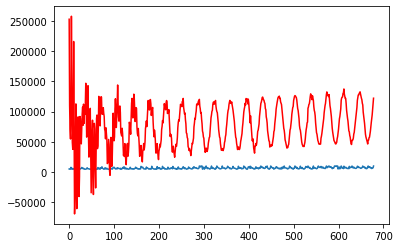

-11.48591672151505
11.72940330389097


In [41]:
# forecast and get the accuracy of the forecast
forcast=res.forecast(steps=len(endog), exog=exog)
#forcast.iloc[:,0].plot()

actual=endog[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=forcast[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]

# plot
pyplot.plot(actual)
pyplot.plot(predicted, color='red')
pyplot.show()

MPE=np.mean((pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MPE)

MAPE=np.mean(abs(pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MAPE)

C:\Users\Rajeev K Pandit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


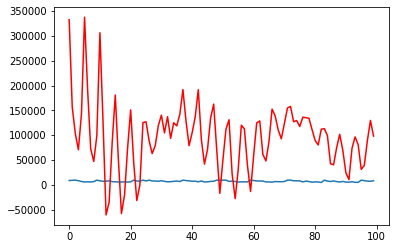

-12.154424553360979
13.049107835949036


In [42]:
##################### forecast on test sample ##############################

endogTest=TestData[['Sales', 'Customers']].astype('float32')
    
exogTest= TestData[['Promo', 'SchoolHoliday',
                        'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
                        'DayOfWeek_4','DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_0', 'SalesSeasonality',
                        'SalesTrend', 'CustSeasonality', 'CustTrend']]
exogTest= exogTest.astype('float32')
endogTest=endogTest.astype('float32')

forcast=res.forecast(steps=len(endogTest), exog=exogTest)
#forcast.iloc[:,0].plot()

actual=endogTest[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=forcast[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]


# plot
pyplot.plot(actual)
pyplot.plot(predicted, color='red')
pyplot.show()

MPE=np.mean((pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MPE)

MAPE=np.mean(abs(pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MAPE)